In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import glob

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
test_df = pd.read_csv('../data/drugcell_all.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
drugs = pd.read_csv('../data/drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']

#nest_drugcell_pred_cv = np.loadtxt('../result/drugcell_cv.predict')
#nest_drugcell_pred_k2 = np.loadtxt('../result/drugcell_k2.predict')
#nest_drugcell_pred_k4 = np.loadtxt('../result/drugcell_k4.predict')
#nest_drugcell_pred_k8 = np.loadtxt('../result/drugcell_k8.predict')
nest_drugcell_pred_k10 = np.loadtxt('../result/drugcell_k10.predict')
#nest_drugcell_pred_k12 = np.loadtxt('../result/drugcell_k12.predict')
drugcell_pred_cv = np.loadtxt('../../drugcell/result/drugcell_cv.predict')
nd_0_pred_k10 = np.loadtxt('../../0_nest_drugcell/result/drugcell_k10.predict')

In [4]:
#Separating data for each drug

def get_drug_pos_map(test_df, drugs):
    drug_pos_map = {d:[] for d in drugs}
    for i, row in test_df.iterrows():
        drug_pos_map[row['D']].append(i)
    return drug_pos_map

In [5]:
#Arrange the drugs in descending order of correlation

def sort_drugs_corr(drugs, test_df, predicted):
    drug_corr_map = {}
    drug_pos_map = get_drug_pos_map(test_df, drugs)
    for d in drugs:
        test_vals = np.take(test_df['AUC'], drug_pos_map[d])
        pred_vals = np.take(predicted, drug_pos_map[d])
        drug_corr_map[d] = stats.spearmanr(test_vals, pred_vals)[0]
    return {drug:corr for drug,corr in sorted(drug_corr_map.items(), key=lambda item:item[1], reverse=True)}


In [6]:
def plot_drug_performance(drug_corr_map):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    x_red = []
    y_red = []
    x_blue = []
    y_blue = []
    for d in drug_corr_map.keys():
        if drug_corr_map[d] > 0.5:
            x_red.append(d)
            y_red.append(drug_corr_map[d])
        else:
            x_blue.append(d)
            y_blue.append(drug_corr_map[d])
    
    ratio = float(len(x_red))/float(len(drug_corr_map.keys()))
    print('Red ratio = ' + str(ratio))
    ax.bar(x_red, y_red, color='red', width=1.0)
    ax.bar(x_blue, y_blue, color='blue', width=1.0)
    ax.set_xticks([])
    ax.set_xlabel('Drugs')
    ax.set_ylabel('Performance\nSpearman ρ (Predicted vs. Actual)')
    plt.show()
    return fig

Red ratio = 0.30994152046783624


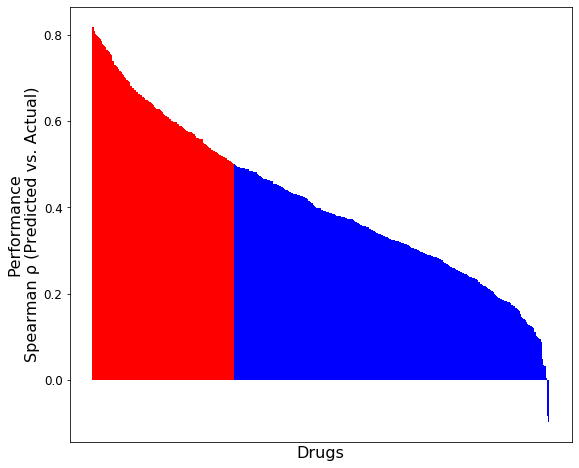

0.39621907024536457


In [7]:
drug_corr_map = sort_drugs_corr(drugs, test_df, nest_drugcell_pred_k10)
fig_nest_drug_perf = plot_drug_performance(drug_corr_map)
print(np.median(list(drug_corr_map.values())))
fig_nest_drug_perf.savefig('../plots/drug_perf.png')

In [8]:
def get_boxplot(test_df, predicted, x_title, y_title):
    
    df = pd.DataFrame(list(zip(test_df['AUC'], predicted)), columns=['t', 'p'])
    df = df.sort_values(by=['t'])

    data = []
    for i in range(9):
        temp = []
        data.append(temp)

    for i, row in df.iterrows():
        if row['t'] < 0.3:
            data[0].append(row['p'])
        elif row['t'] < 0.4:
            data[1].append(row['p'])
        elif row['t'] < 0.5:
            data[2].append(row['p'])
        elif row['t'] < 0.6:
            data[3].append(row['p'])
        elif row['t'] < 0.7:
            data[4].append(row['p'])
        elif row['t'] < 0.8:
            data[5].append(row['p'])
        elif row['t'] < 0.9:
            data[6].append(row['p'])
        elif row['t'] < 1.0:
            data[7].append(row['p'])
        else:
            data[8].append(row['p'])
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.boxplot(data, showfliers=False, widths=0.99, patch_artist=True)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticks(np.arange(.5, 10, 1))
    ax.set_xticklabels(['0', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', 'Inf'])
    ax.grid(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()
    
    return fig


In [9]:
def compare_corr(x_test_df, y_test_df, x_label, y_label, x_title, y_title):
    X_corr = []
    Y_corr = []
    x_drug_pos_map = get_drug_pos_map(x_test_df, drugs)
    y_drug_pos_map = get_drug_pos_map(y_test_df, drugs)
    for d in drugs:
        x_test_vals = np.take(x_test_df['AUC'], x_drug_pos_map[d])
        y_test_vals = np.take(y_test_df['AUC'], y_drug_pos_map[d])
        X_vals = np.take(x_label, x_drug_pos_map[d])
        Y_vals = np.take(y_label, y_drug_pos_map[d])
        X_c = stats.spearmanr(X_vals, x_test_vals)[0]
        Y_c = stats.spearmanr(Y_vals, y_test_vals)[0]
        X_corr.append(X_c)
        Y_corr.append(Y_c)

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    ax.scatter(X_corr, Y_corr, s = 10)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    
    return X_corr, Y_corr, fig

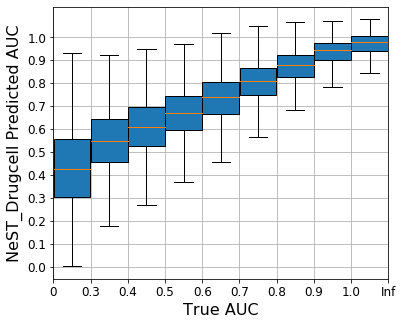

In [10]:
#NeST Drugcell

fig1 = get_boxplot(test_df, nest_drugcell_pred_k10, "True AUC", "NeST_Drugcell Predicted AUC")

In [11]:
fig1.savefig('../plots/nest_drugcell_auc.png')

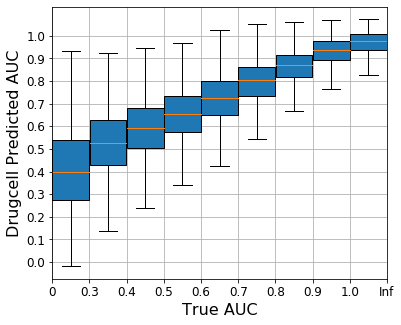

In [65]:
#Drugcell

fig2 = get_boxplot(test_df, drugcell_pred_cv, "True AUC", "Drugcell Predicted AUC")

In [66]:
fig2.savefig('../plots/drugcell_auc.png')

In [12]:
sum = 0.0
for i in range(1, 6):
    test_file = '../data/' + str(i) + '_drugcell_test.txt'
    pred_file = '../result/' + str(i) + '_drugcell.predict'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    pred = np.loadtxt(pred_file)
    corr = stats.spearmanr(pred, test)[0]
    sum += corr
print('NeST DrugCell Correlation: {:.3f}'.format(sum/5.0))

NeST DrugCell Correlation: 0.776


In [25]:
sum = 0.0
for i in range(1, 6):
    test_file = '../../drugcell/data/' + str(i) + '_drugcell_test.txt'
    pred_file = '../../drugcell/result/' + str(i) + '_drugcell.predict'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    pred = np.loadtxt(pred_file)
    corr = stats.spearmanr(pred, test)[0]
    sum += corr
print('DrugCell Correlation: {:.3f}'.format(sum/5.0))

DrugCell Correlation: 0.767


In [18]:
corr = stats.spearmanr(nest_drugcell_pred_cv, test_df['AUC'])[0]
print('NeST DrugCell K=6: {:.3f}'.format(corr))

NeST DrugCell K=6: 0.769


In [20]:
corr = stats.spearmanr(nest_drugcell_pred_k2, test_df['AUC'])[0]
print('NeST DrugCell K=2: {:.3f}'.format(corr))

NeST DrugCell K=2: 0.762


In [21]:
corr = stats.spearmanr(nest_drugcell_pred_k4, test_df['AUC'])[0]
print('NeST DrugCell K=4: {:.3f}'.format(corr))

NeST DrugCell K=4: 0.767


In [6]:
corr = stats.spearmanr(nest_drugcell_pred_k8, test_df['AUC'])[0]
print('NeST DrugCell K=8: {:.3f}'.format(corr))

NeST DrugCell K=8: 0.774


In [22]:
corr = stats.spearmanr(nest_drugcell_pred_k10, test_df['AUC'])[0]
print('NeST DrugCell K=10: {:.3f}'.format(corr))

NeST DrugCell K=10: 0.776


In [23]:
corr = stats.spearmanr(nest_drugcell_pred_k12, test_df['AUC'])[0]
print('NeST DrugCell K=12: {:.3f}'.format(corr))

NeST DrugCell K=12: 0.775


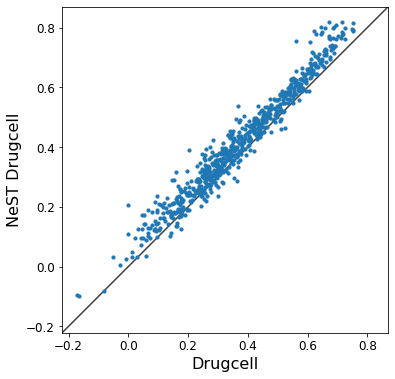

4.527871122860145e-06

In [13]:
X_c, Y_c, fig_dc = compare_corr(test_df, test_df, drugcell_pred_cv, nest_drugcell_pred_k10, "Drugcell", "NeST Drugcell")
stats.ttest_ind(X_c, Y_c)[1]

In [67]:
fig_dc.savefig('../plots/nest_drugcell_vs_drugcell.png', bbox_inches = 'tight')

0.305780780362427

Elastic Net: 0.745


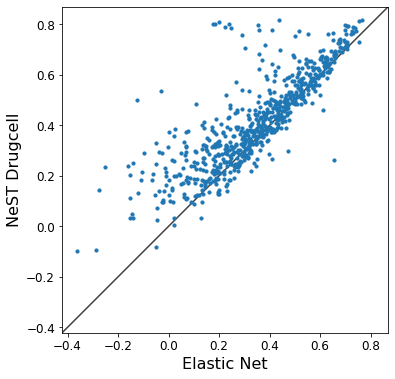

1.3909045089702676e-11

In [12]:
elastic_net_pred = np.loadtxt('../result/elastic_net.predict')
corr = stats.spearmanr(elastic_net_pred, test_df['AUC'])[0]
print('Elastic Net: {:.3f}'.format(corr))

X_c, Y_c, fig_en = compare_corr(test_df, test_df, elastic_net_pred, nest_drugcell_pred_k10, "Elastic Net", "NeST Drugcell")
stats.ttest_ind(X_c, Y_c)[1]

In [ ]:
fig_en.savefig('../plots/nest_drugcell_vs_elastic_net.png', bbox_inches = 'tight')

Red ratio = 0.23976608187134502


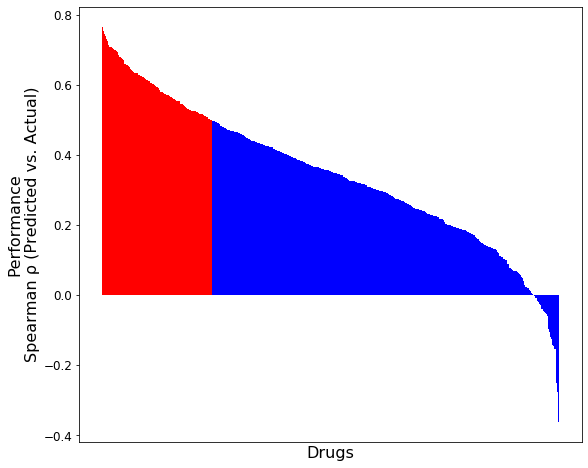

0.35263120103047596


In [96]:
en_drug_corr_map = sort_drugs_corr(drugs, test_df, elastic_net_pred)
fig_elasticnet_drug_perf = plot_drug_performance(en_drug_corr_map)
print(np.median(list(en_drug_corr_map.values())))
fig_elasticnet_drug_perf.savefig('../plots/en_drug_perf.png')

In [10]:
sum = 0.0
for i in range(10):
    test_no = (i % 5) + 1
    pred_no = i + 1
    test_file = '../../ann_nest_drugcell/data/' + str(test_no) + '_drugcell_test.txt'
    pred_file = '../../ann_nest_drugcell/result/' + str(pred_no) + '_drugcell.predict'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    pred = np.loadtxt(pred_file)
    corr = stats.spearmanr(pred, test)[0]
    sum += corr
print('Matched NN: {:.3f}'.format(sum/10.0))

Matched NN: 0.776


Matched NN: 0.774


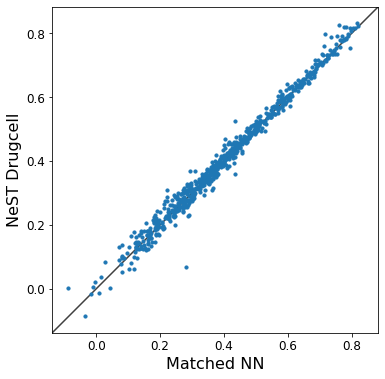

0.6029878729872941

In [72]:
test_r10_df = pd.read_csv('../../ann_nest_drugcell/data/drugcell_test_r10.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
ann_pred_r10 = np.loadtxt('../../ann_nest_drugcell/result/drugcell_r10.predict')

corr = stats.spearmanr(ann_pred_r10, test_r10_df['AUC'])[0]
print('Matched NN: {:.3f}'.format(corr))

X_c, Y_c, fig_nn = compare_corr(test_r10_df, test_df, ann_pred_r10, nest_drugcell_pred_k10, "Matched NN", "NeST Drugcell")
stats.ttest_ind(X_c, Y_c)[1]

In [74]:
fig_nn.savefig('../plots/nest_drugcell_vs_matched_nn.png', bbox_inches = 'tight')

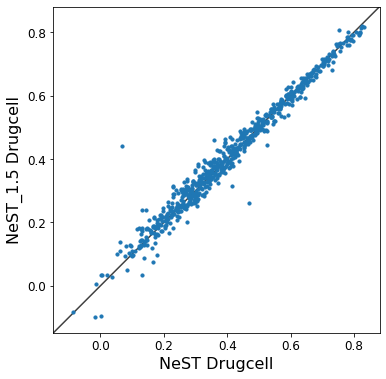

0.6188173352999816

In [14]:
X_c, Y_c, fig_ndc = compare_corr(test_df, test_df, nd_0_pred_k10, nest_drugcell_pred_k10, "NeST Drugcell", "NeST_1.5 Drugcell")
stats.ttest_ind(X_c, Y_c)[1]